In [1]:
%load_ext autoreload
%autoreload 2

## import

In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

from src.config import load_config
from src.models import build_mlp, build_logistic_regressor
from src.metrics import DEFAULT_REGRESSION_METRICS
from src.trainer import Trainer
from src.evaluate import evaluate_on_npz
from src.utils import print_tensor
from src.visu import plot_pred_vs_true, plot_residuals

## Config

In [3]:
root_exp_dir = Path("runs/002-cv_on_best_trial_logistic")

config_path = Path("runs/001-sweep_experiment-logistic/trials/trial_012/config.yaml") # root_exp_dir / 'hparams' / 'config.yaml'
assert config_path.exists(), f"Config file not found: {config_path}"
print(f"Loading config from: {config_path}  ")
cfg = load_config(config_path)
cfg.print()

Loading config from: runs\001-sweep_experiment-logistic\trials\trial_012\config.yaml  

===== Current Configuration =====
model:
  name: logistic_regression
  input_dim: 6
  hidden_dims:
  - 256
  activation: relu
  dropout: 0.0
  output_dim: 1
data:
  dataset: real
  npz_path: data/preprocessed/cleaned_x_y_hot.npz
  batch_size: 2048
  seed: 42
  normalize_x: true
  x_norm_method: minmax
  normalize_y: true
  y_norm_method: minmax
  return_stats: true
  val_ratio: 0.2
optim:
  name: adam
  lr: 0.008211568960263007
  weight_decay: 1.0227833166821117e-05
  momentum: 0.9
train:
  num_epochs: 100
  log_interval: 5
  device: cuda
logging:
  root_dir: ./runs
  experiment_name: 001-sweep_experiment-logistic/trials/trial_012
  subdir_checkpoints: checkpoints
  subdir_logs: logs
  subdir_hparams: hparams
checkpoint:
  save_best: true
  save_last: false
  monitor: val_loss
  mode: min
cv:
  n_splits: 1
  shuffle: true
  seed: 42




## Trainer

In [6]:
# Model
model = build_mlp(cfg.model) if cfg.model.name == 'mlp' else build_logistic_regressor(cfg.model)
ckpt_path = "runs/001-sweep_experiment-logistic/trials/trial_012/checkpoints/best.pt" # root_exp_dir / 'folds' / 'fold_000' / 'checkpoints' / 'best.pt'
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt['model_state'], strict=True)

# Trainer
trainer = Trainer(
    model=model,
    optimizer=None,
    loss_fn=torch.nn.MSELoss(),
    train_cfg=cfg.train,
    logging_cfg=cfg.logging,
    checkpoint_cfg=cfg.checkpoint,
    metrics=DEFAULT_REGRESSION_METRICS,
)



*** Using device: cuda ***



In [10]:
TEST_NPZ_PATH = "data/preprocessed/cleaned_x_y_hot.npz"

scaler_stats_path = root_exp_dir / 'hparams' / 'scaler_stats.npz'
stats = np.load(scaler_stats_path)
y_method, y_min, y_max = stats['y_method'].item(), stats['y_min'], stats['y_max']
print(f"Loaded scaler stats from: {scaler_stats_path}")
print(f"y scaling method: {y_method}")
print(f"y min: {y_min}")
print(f"y max: {y_max}")

out_dict = evaluate_on_npz(
    trainer,
    TEST_NPZ_PATH,
    scaler_stats_path,
    sample_rate=0.1,
    batch_size=2048,
    norm_method="minmax",
    return_raw_outputs=True,
)

Loaded scaler stats from: runs\002-cv_on_best_trial_logistic\hparams\scaler_stats.npz
y scaling method: minmax
y min: 0.0
y max: 33.85419845581055
[INFO] Sampled 866 / 8665 from data/preprocessed/cleaned_x_y_hot.npz

Test Evaluation
Loss: 0.013121
     mse: 0.013121
     mae: 0.085679
    rmse: 0.114548
      r2: 0.718383


In [11]:
test_loss = out_dict['loss']
test_metrics = out_dict['metrics']
preds = out_dict['preds']
targets = out_dict['targets']

print_tensor(preds, "preds")
print_tensor(targets, "targets")

preds          : shape: torch.Size([866]), min: 0.0371, max: 0.6950, mean: 0.2578, std: 0.1324
targets        : shape: torch.Size([866]), min: 0.0240, max: 1.0000, mean: 0.2549, std: 0.2160


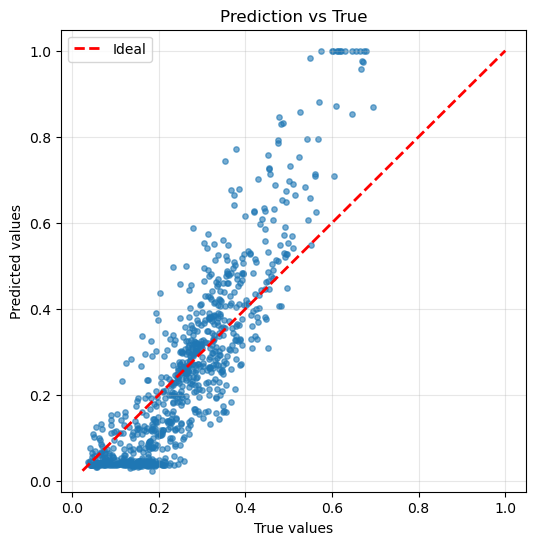

In [12]:
kwargs = {"figsize": (6,6), "s": 15}
preds = preds.cpu()
targets = targets.cpu()

# # Scale back to original range
# if y_method == 'minmax':
# 	preds_unscaled = preds * (y_max - y_min) + y_min
# 	targets_unscaled = targets * (y_max - y_min) + y_min
# 	print("\nRescaled preds and targets back to original range using min-max scaling.")
# elif y_method == 'standard':
# 	preds_unscaled = preds * y_max + y_min
# 	targets_unscaled = targets * y_max + y_min
# 	print("\nRescaled preds and targets back to original range using standard scaling.")

plot_pred_vs_true(preds, targets, **kwargs)

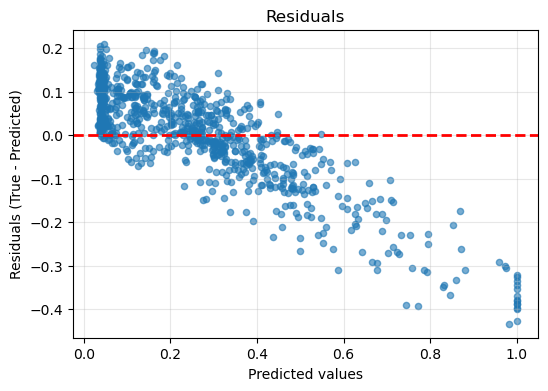

In [13]:
plot_residuals(preds, targets)